# Fokker-Planck Score Learning (FPSL): Learning Free Energy Landscapes

Fokker--Planck Score Learning (FPSL) is a framework for learning equilibrium free energy profiles from non-equilibrium steady state data. It employs the steady-state solution of the Fokker--Planck equation as an ansatz in the denoising score learning scheme.

In the following, we will reproduce the toy model results from the main paper. Just for reference: Using an Nvidia 4060 GTX, running this notebook takes around 5 minutes.

## Imports

In [1]:
%env XLA_PYTHON_CLIENT_PREALLOCATE = false

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


In [2]:
import jax
import numpy as np
import prettypyplot as pplt
import jax_dataloader as jdl
from jax import numpy as jnp
from matplotlib import pyplot as plt
from matplotlib import colors

from fpsl.datasets.datasets import (
    WPotential1D,
    BiasedForceWPotential1D,
)
from fpsl import FPSL

# fix random seeds
key = jax.random.key(42)
jdl.manual_seed(42)
np.random.seed(42)


# ddpm training
n_epochs = 50
mlp_network = [96, 96, 96, 96]
batch_size = 2056
lrs = (5e-3, 5e-7)
sigma_min = 0.01
sigma_max = 0.5
fourier_feat = 4
n_samples = batch_size * 512


# setup plotting style
pplt.use_style(
    colors='paula',
    figsize=(1, 1),
    cmap='plasma',
    true_black=True,
)
plt.rcParams['figure.dpi'] = 200
cnorm = colors.SymLogNorm(
    linthresh=0.1, linscale=1, vmin=-20, vmax=20, base=10,
)

Since we are training an MLP in this notebook it is important to use an GPU. The following will print how jax is initialized. If it shows `CPU`, but a GPU is available, you should install this package with `uv sync --extra cuda` or `pip install fpsl[cuda]`.

In [3]:
jax.devices()

[CudaDevice(id=0)]

## Generate Toy Model Data

We start here with generating toy model data, to reproduce results from the main paper. Since we only need a training set of positions as external bias forces (typically constant) $(x_t, f_t)$ pairs, this can then be easily extended to MD simulation data.

In [4]:
def generate_data(ext_forces, key, pot):
    """Generate toy model data for training."""
    Xs = {}
    for ext_force in ext_forces:
        key, _ = jax.random.split(key)
        bwpot = pot(
            bias=lambda x, t: ext_force * jnp.ones_like(x),
        )
        samples = bwpot.sample(
            key=key,
            n_samples=n_samples,
        )
        Xs[int(ext_force)] = samples

    return Xs, key


# we pick here 3 different external forces to show how different simulations can be used to learn the same potential
ext_forces = np.geomspace(3, 30, 4).astype(int)

Xs, key = generate_data(
    ext_forces=ext_forces,
    key=key,
    pot=BiasedForceWPotential1D,
)

Now let us plot the sampled data.

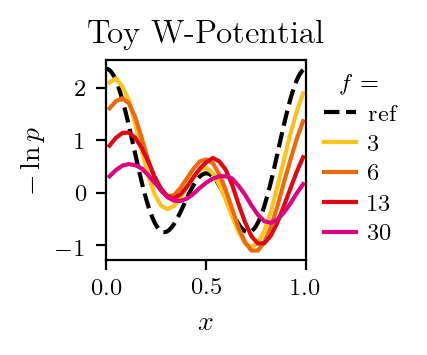

<Figure size 200x200 with 0 Axes>

In [5]:
fig, ax = plt.subplots()

# plot reference potential
WPotential1D().plot_potential()

bins = jnp.linspace(0, 1, 32)
for ext_force in ext_forces:
    hist, _ = np.histogram(
        Xs[ext_force],
        bins=bins,
        density=True,
    )

    ax.plot(
        0.5 * (bins[1:] + bins[:-1]),
        -np.log(hist),
        label=ext_force,
    )

ax.set_xlim(0, 1)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$-\ln p$')
ax.grid(False)
pplt.legend(outside='right', frameon=False, title='$f=$')
pplt.show()

## Training the Denoising Score Model

In the following we train for each external force a denoising score model (DSM) using the `fpsl` package. The training is done with the `train_dms` function, which takes the sampled data and the external forces as input. The training is done for a fixed number of epochs and the loss is plotted.

In [6]:
def train_dms(Xs, key, sigma_min, ext_forces):
    ddms = {}
    fig, ax = plt.subplots()
    for ext_force in ext_forces:
        key, _ = jax.random.split(key)
        ddm = FPSL(
            mlp_network=mlp_network,
            key=key,
            n_epochs=n_epochs,
            batch_size=batch_size,
            sigma_max=sigma_max,
            sigma_min=sigma_min,
            fourier_features=fourier_feat,
            warmup_steps=n_epochs // 10,
        )

        loss = ddm.train(
            Xs[ext_force],
            y=jnp.full((len(Xs[ext_force]), 1), ext_force),
            lrs=lrs,
        )['train_loss']
        ddms[ext_force] = ddm

        ax.plot(np.arange(1, n_epochs + 1), loss)

    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    pplt.show()

    return ddms, key

To visualize the learned denoising score model, we plot the learned energy and score function as functions of the diffusion time and position.

In [7]:
def plot_score_energy(ddpm, axs=None):
    xs = jnp.linspace(0, 1, 50).reshape(-1, 1)
    ts = jnp.linspace(0, 1, 51)

    if axs is None:
        fig, axs = plt.subplots(
            1, 2,
            gridspec_kw={'wspace': 2 / 3},
        )

    ax = axs[0]
    score = jnp.array([
        ddpm.score(xs, t).flatten()
        for t in ts
    ])

    im = ax.pcolormesh(
        xs.flatten(), ts, score,
        norm=cnorm,
        cmap='Spectral',
    )
    pplt.colorbar(im, ax=ax, label=r'$\nabla \ln p$')
    ax.set_title('score')

    ax = axs[1]
    energy = jnp.array([
        ddpm.energy(xs, t).flatten()
        for t in ts
    ])
    energy -= energy.min(axis=1, keepdims=True)
    p = np.exp(-energy)
    p /= p.sum(axis=1, keepdims=True) * (xs[1] - xs[0])

    im = ax.pcolormesh(
        xs.flatten(), ts, np.log(p), vmin=max(-5, np.log(p.min())),
    )
    pplt.colorbar(im, ax=ax, label=r'$\ln p$')
    ax.set_title('energy')

    for ax in axs:
        ax.grid(False)
        ax.set_xlabel('$x$')
        ax.set_ylabel('$t$')

    if axs is None:
        pplt.label_outer(axs=axs)
        pplt.show()

def plot_score_energy_all(dms):
    fig, axs = plt.subplots(
        2, len(dms),
        gridspec_kw={'wspace': 2/3, 'hspace': 1 / 3},
    )

    for idx, (label, dm) in enumerate(dms.items()):
        ax_col = axs[:, idx]
        plot_score_energy(dm, axs=ax_col)

        pplt.text(
            0.5,
            1.4,
            f'$f={label}$' if label != 'all' else 'all',
            ax=ax_col[0],
            transform=ax_col[0].transAxes,
            size='x-large',
        )

    pplt.label_outer(axs=axs)
    pplt.show()

Finally, we plot the reference energy and the learned energy to visualize the learned free energy landscape.

In [8]:
def plot_final_potential(dms, pot):
    fig, axs = plt.subplots(
        1, len(dms),
        gridspec_kw={'wspace': 0},
        figsize=(1, 1),
    )

    for idx, (label, dm) in enumerate(dms.items()):
        plt.sca(axs[idx])
        pot.plot_potential()

        xs = np.linspace(0, 1, 200)
        energy = dm.energy(xs.reshape(-1, 1), t=0.0).flatten()
        p = np.exp(-energy)
        p /= p.sum() * (xs[1] - xs[0])
        axs[idx].plot(xs, - np.log(p))

        axs[idx].set_title(f'$f={label}$' if label != 'all' else 'all')
        axs[idx].set_xlim(0, 0.99)

    pplt.label_outer()
    pplt.show()

loss=0.2851/0.2848: 100%|██████████| 50/50 [01:08<00:00,  1.36s/it]


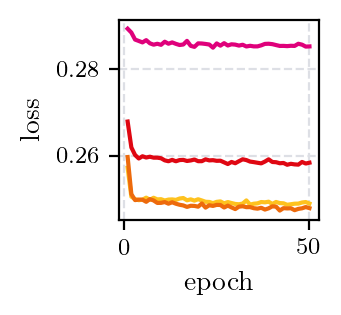

<Figure size 200x200 with 0 Axes>

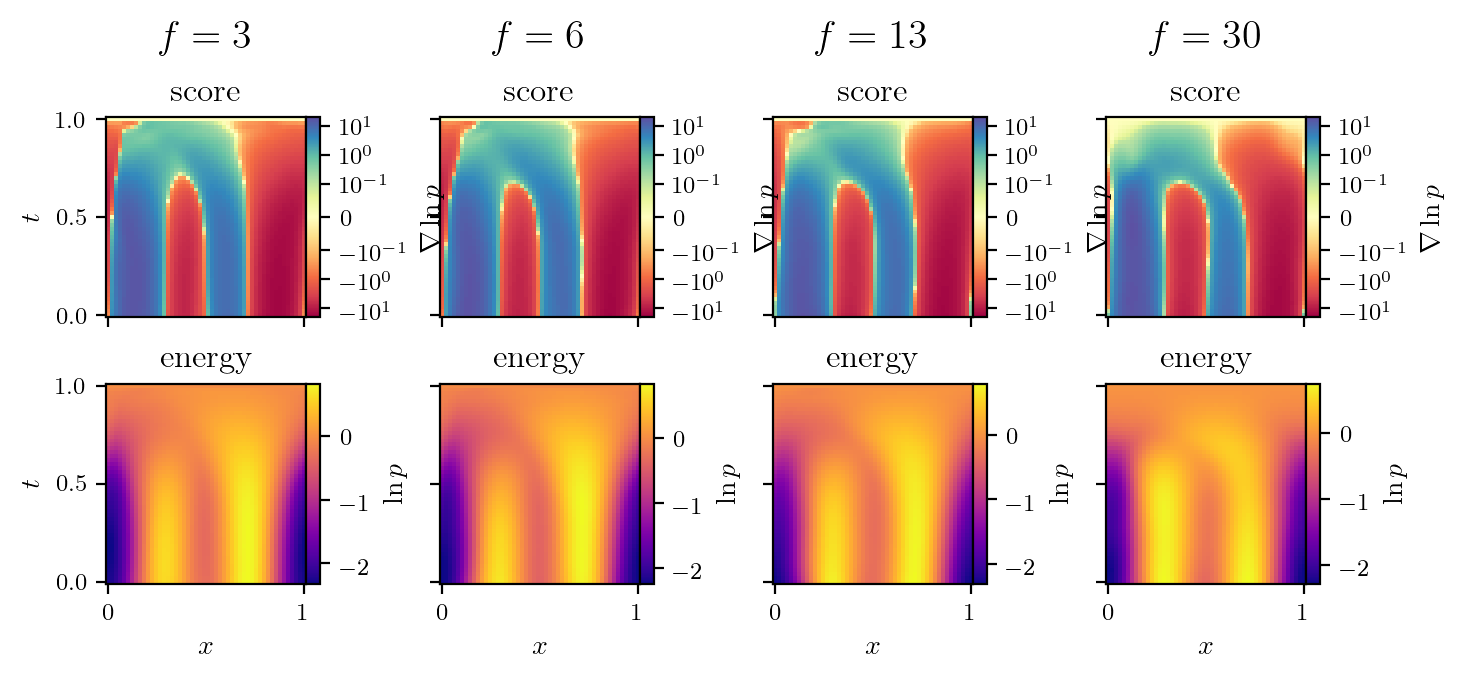

<Figure size 200x200 with 0 Axes>

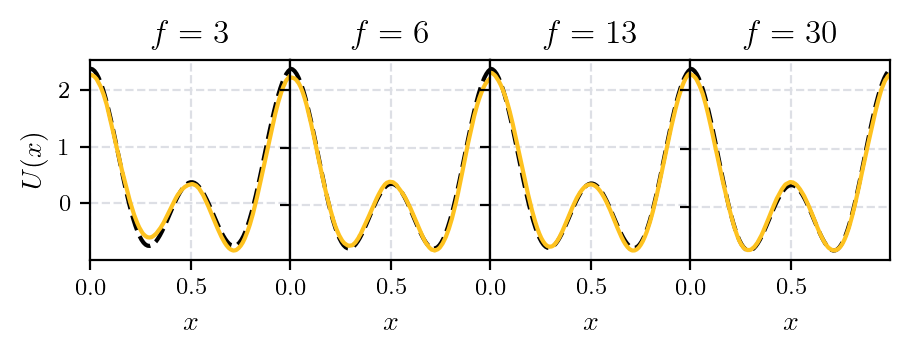

<Figure size 200x200 with 0 Axes>

In [9]:
dpdms, key = train_dms(Xs, key, sigma_min, ext_forces)
plot_score_energy_all(dpdms)
plot_final_potential(dpdms, pot=WPotential1D())

We find that even with this short training time, all models were able to learn the correct free energy landscape. The learned energy profiles are very close to the reference energy profile. This shows that the FPSL framework is able to learn the free energy landscape from non-equilibrium steady state data. However, what should be noted is that for intermediate diffusion times, these models are not fully converged yet. But since, we are only interested in the equilibrium free energy profile, this is not a problem.